# Filling gaps - merged dataset - 2 sequences input - attention mechanism
---
The notebook contains the code used in the process of preparing datasets and training neural network models with differing architecture, in order to analyse their capabilities in filling gaps present in aminoacid sequences. In this experiment, two sequences were an input for a model with attention mechanism.

---
Import necessary libraries.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from keras.layers import (Input, LSTM, Dot, Softmax, Multiply, Concatenate, Dense, Bidirectional, Flatten, GRU)
from keras.models import Sequential
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.optimizers.legacy import Adam
from keras.utils.vis_utils import plot_model
from keras.models import Model


---
Function to put gaps in sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Data_preparation.ipynb) notebook).

In [2]:
def gap_sequences(column, gaps, repeat=1):
  inds = []
  seqs = []
  gapped = []

  for i in range(repeat):
    for seq in column:
      seqs.append(seq)
      inds = [i for i, _ in enumerate(seq)]

      samp = random.sample(inds, gaps)

      for index in samp:
        seq = seq[:index] + "_" + seq[index + 1:]

      gapped.append(seq)

  return seqs, gapped

---
Function to perform one-hot encoding on sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Data_preparation.ipynb) notebook).

In [3]:
char_to_int = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
               'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
               'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
               'Y': 19, '_': 20}

def one_hot_encoding(seqs, length=1):
  n_rows = len(seqs)
  max_seq_len = max(len(seqs[i]) for i in range(n_rows))
  max_len = max(max_seq_len, length)
  n_classes = len(char_to_int)

  encoded = np.zeros((n_rows, max_len, n_classes))

  for i in range(n_rows):
      seq = seqs[i]
      for j, letter in enumerate(seq):
        encoded[i, j, char_to_int[letter.upper()]] = 1

  return encoded

---
The code defines an attention model using LSTM layers. It takes three inputs, which are processed separately by LSTM encoders. An attention mechanism is then applied to capture the relationship between the gapped interactor sequences (gapped1) and full interactee sequences (full2).

Steps of the algorithm:
1. Define input shapes.
2. Create input layers for each input shape.
3. Create LSTM encoder layers for two inputs.
4. Compute attention weights using dot product and apply softmax activation.
5. Perform weighted sum using attention weights and one of the inputs.
6. Concatenate inputs and weighted sum.
7. Apply LSTM layer to the concatenated input.
8. Add a dense layer with softmax activation for output.

In [11]:
def attention_model():
  input_shape_gapped1 = (65, 21)
  input_shape_full2 = (65, 21)
  input_shape_full1 = (65, 21)

  # Define the inputs
  input_gapped1 = Input(shape=input_shape_gapped1)
  input_full2 = Input(shape=input_shape_full2)
  input_full1 = Input(shape=input_shape_full1)

  # Encoder for gapped1
  encoder_gapped1 = LSTM(64, return_sequences=True)(input_gapped1)

  # Encoder for full2
  encoder_full2 = LSTM(64, return_sequences=True)(input_full2)

  # Attention mechanism
  attention_weights = Dot(axes=[2, 2])([encoder_gapped1, encoder_full2])
  attention_weights = Softmax(axis=1)(attention_weights)

  # Weighted sum using attention weights
  weighted_sum = Dot(axes=[2, 1])([attention_weights, encoder_full2])

  # Decoder
  decoder_input = Concatenate(axis=-1)([encoder_gapped1, weighted_sum])
  decoder_output = LSTM(64, return_sequences=True)(decoder_input)
  decoder_output = Dense(input_shape_full1[-1], activation='softmax')(decoder_output)

  # Create the model
  model = Model(inputs=[input_gapped1, input_full2, input_full1], outputs=decoder_output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy'])
  return model

---
Function displaing and saving plots of loss function, accuracy and top-5
categorical accuracy in the training process of all models.

It accepts a list of results of training and a title with which plots will be saved to PNG files.

In [4]:
def show_plots(results, title):
  # Plot 1: Training and Validation Loss
  fig1, ax1 = plt.subplots(figsize=(10, 5))
  # plot training loss vs. epochs
  ax1.plot(results.history['loss'], label="train")
  # plot validation loss vs. epochs
  ax1.plot(results.history['val_loss'], label="test", linestyle='dashed')

  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend()
  ax1.set_xlim([0, 150])

  # Plot 2: Training and Validation Accuracy
  fig2, ax2 = plt.subplots(figsize=(10, 5))
  # plot training accuracy vs. epochs
  ax2.plot(results.history['accuracy'], label="train")
  # plot validation accuracy vs. epochs
  ax2.plot(results.history['val_accuracy'], label="test", linestyle='dashed')

  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy [-]")
  ax2.legend()
  ax2.set_xlim([0, 150])
  ax2.set_ylim([0, 1])

  # Plot 3: Training and Validation Top-K Categorical Accuracy
  fig3, ax3 = plt.subplots(figsize=(10, 5))
  # plot training top-k accuracy vs. epochs
  ax3.plot(results.history['top_k_categorical_accuracy'], label="train")
  # plot validation top-k accuracy vs. epochs
  ax3.plot(results.history['val_top_k_categorical_accuracy'],  label="test", linestyle='dashed')

  ax3.set_xlabel("Epoch")
  ax3.set_ylabel("Top-K Categorical Accuracy [-]")
  ax3.legend()
  ax3.set_xlim([0, 150])
  ax3.set_ylim([0, 1])

  # Save the figures
  fig1.savefig(f"{title}_loss.png")
  fig2.savefig(f"{title}_accuracy.png")
  fig3.savefig(f"{title}_top_k_accuracy.png")

  # Show the figures
  plt.show()

---
Open the file with merged dataset and split into train and test data in proportion 4:1.

In [5]:
data = pd.read_csv("merged_data.csv")

seq_or = data["interactor"]
seq_ee = data["interactee"]

data = pd.DataFrame(list(zip(seq_or, seq_ee)))

data_train, data_test = train_test_split(data, test_size=0.2, random_state=73)

print(f"Length of train dataset: {len(data_train)}")
print(f"Length of test dataset: {len(data_test)}")

Length of train dataset: 480
Length of test dataset: 120


---
Create datasets with:
* 1 gap
* 3 gaps
* 5 gaps

In [6]:
train_1_full, train_1_gapped = gap_sequences(data_train[0], 1, 1)
test_1_full, test_1_gapped = gap_sequences(data_test[0], 1, 1)

train_3_full, train_3_gapped = gap_sequences(data_train[0], 3, 1)
test_3_full, test_3_gapped = gap_sequences(data_test[0], 3, 1)

train_5_full, train_5_gapped = gap_sequences(data_train[0], 5, 1)
test_5_full, test_5_gapped = gap_sequences(data_test[0], 5, 1)

---
Perform one-hot encoding and assign resulting arrays to variables used in the models' training process.

In [7]:
X_train_g_1 = one_hot_encoding(train_1_gapped, 65)
X_train_f_1 = one_hot_encoding(data_train[1].tolist(), 65)
y_train_1 = one_hot_encoding(train_1_full, 65)

X_test_g_1 = one_hot_encoding(test_1_gapped, 65)
X_test_f_1 = one_hot_encoding(data_test[1].tolist(), 65)
y_test_1 = one_hot_encoding(test_1_full, 65)

X_train_g_3 = one_hot_encoding(train_3_gapped, 65)
X_train_f_3 = one_hot_encoding(data_train[1].tolist(), 65)
y_train_3 = one_hot_encoding(train_3_full, 65)

X_test_g_3 = one_hot_encoding(test_3_gapped, 65)
X_test_f_3 = one_hot_encoding(data_test[1].tolist(), 65)
y_test_3 = one_hot_encoding(test_3_full, 65)

X_train_g_5 = one_hot_encoding(train_5_gapped, 65)
X_train_f_5 = one_hot_encoding(data_train[1].tolist(), 65)
y_train_5 = one_hot_encoding(train_5_full, 65)

X_test_g_5 = one_hot_encoding(test_5_gapped, 65)
X_test_f_5 = one_hot_encoding(data_test[1].tolist(), 65)
y_test_5 = one_hot_encoding(test_5_full, 65)

Create a model with attention using *attention_model* function and train it with data with one gap.

In [12]:
model = attention_model()
history_1 = model.fit([X_train_g_1, X_train_f_1, y_train_1], y_train_1, epochs=150, verbose=0, validation_data=([X_test_g_1, X_test_f_1, y_test_1], y_test_1))

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

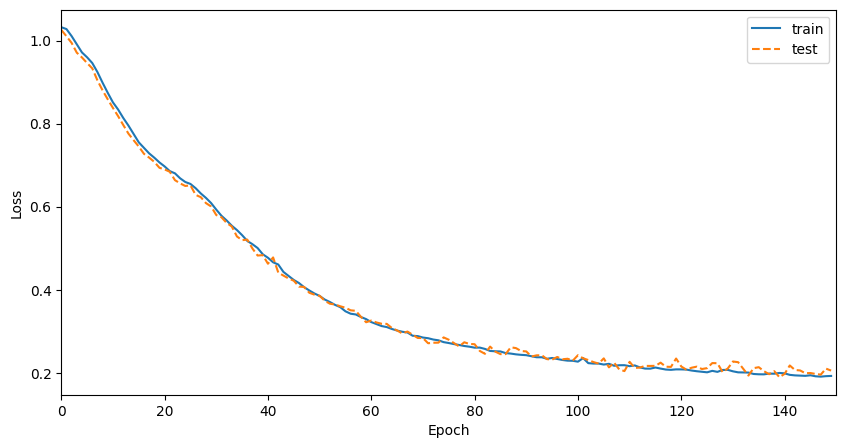

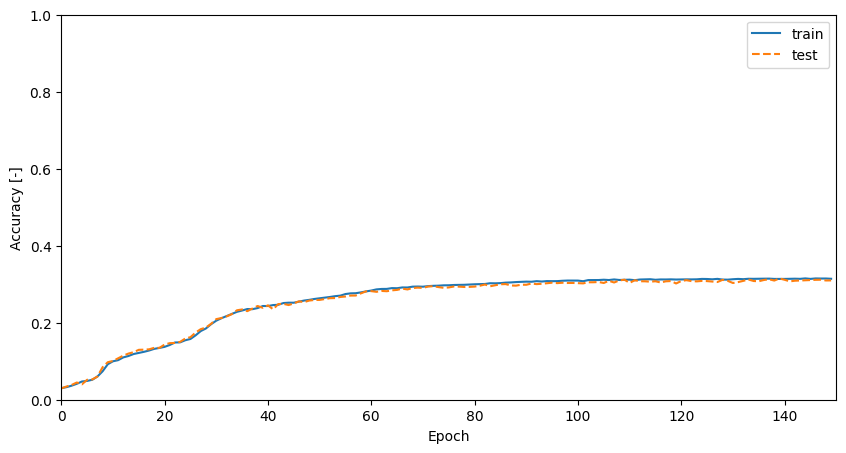

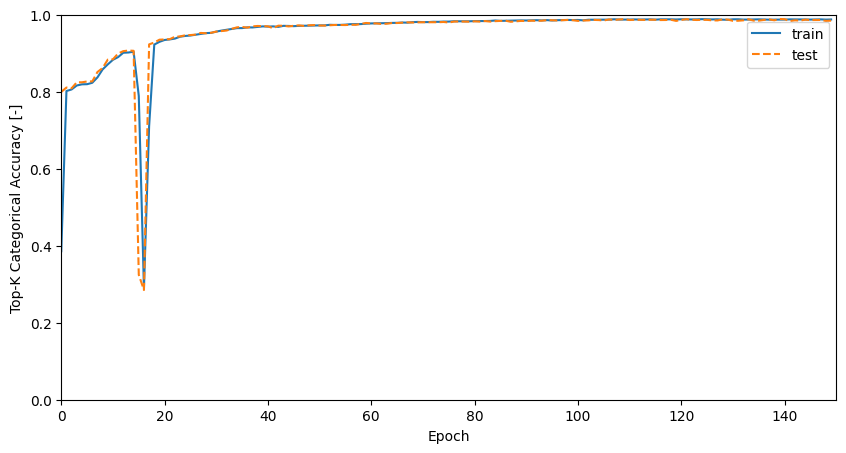

In [13]:
show_plots(history_1, "att_1gap")

---
Create a model with attention using *attention_model* function and train it with data with three gaps.

In [14]:
model = attention_model()
history_3 = model.fit([X_train_g_3, X_train_f_3, y_train_3], y_train_3, epochs=150, verbose=0, validation_data=([X_test_g_3, X_test_f_3, y_test_3], y_test_3))

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

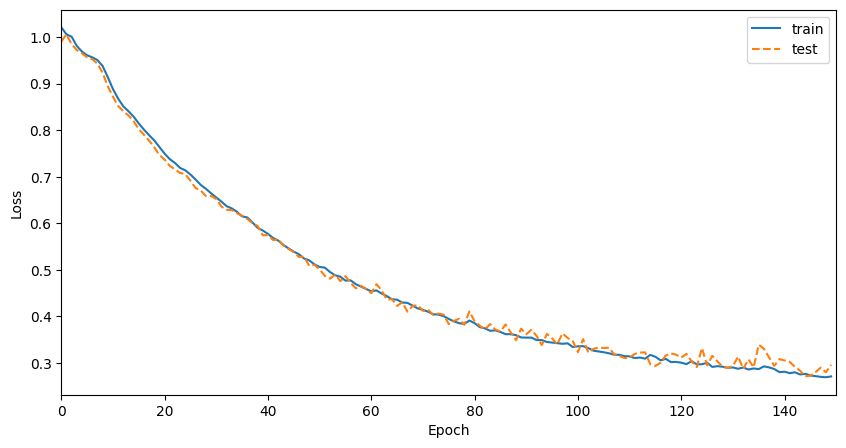

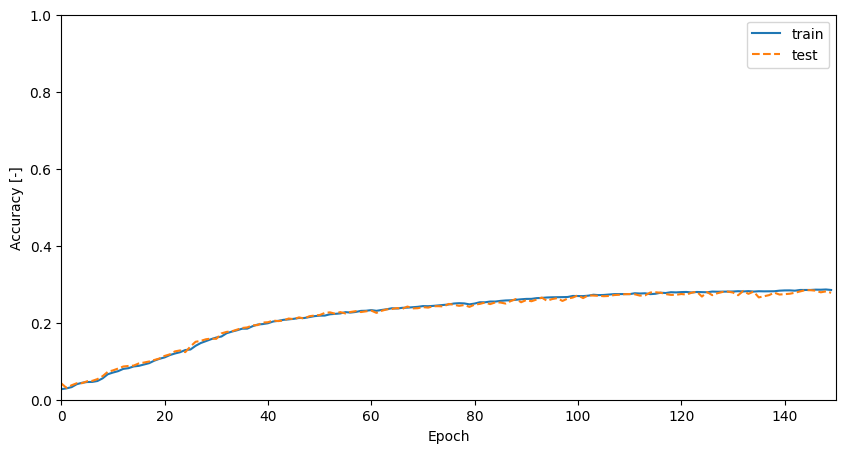

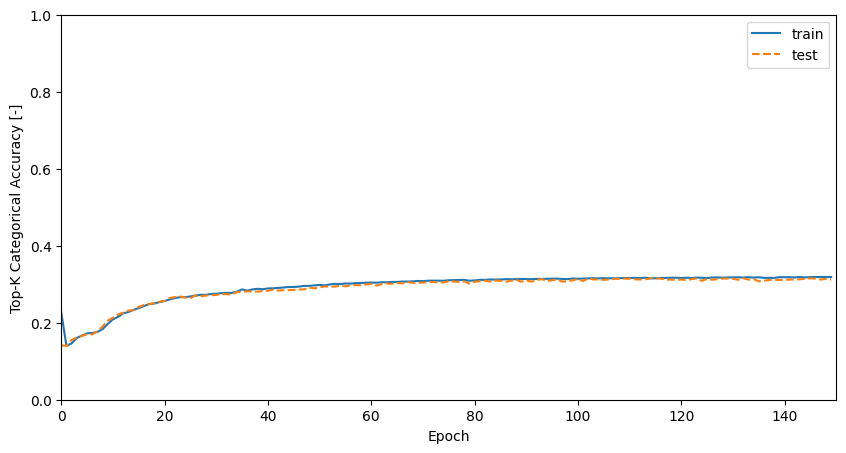

In [15]:
show_plots(history_3, "att_3gap")

---
Create a model with attention using *attention_model* function and train it with data with five gaps.

In [16]:
model = attention_model()
history_5 = model.fit([X_train_g_5, X_train_f_5, y_train_5], y_train_5, epochs=150, verbose=0, validation_data=([X_test_g_5, X_test_f_5, y_test_5], y_test_5))

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

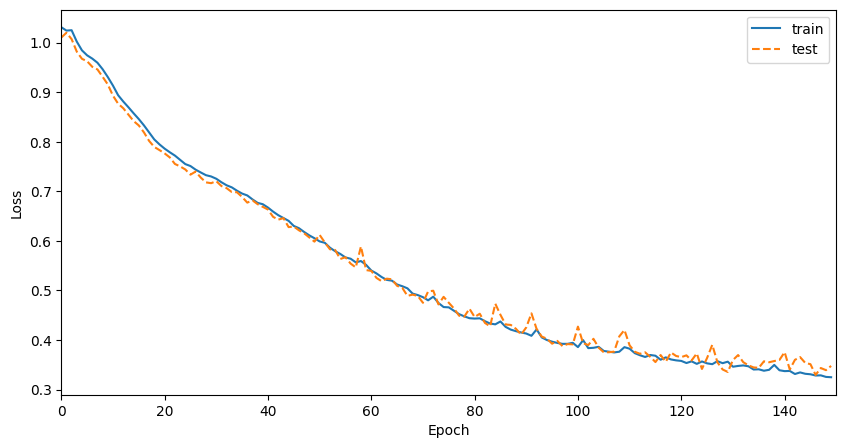

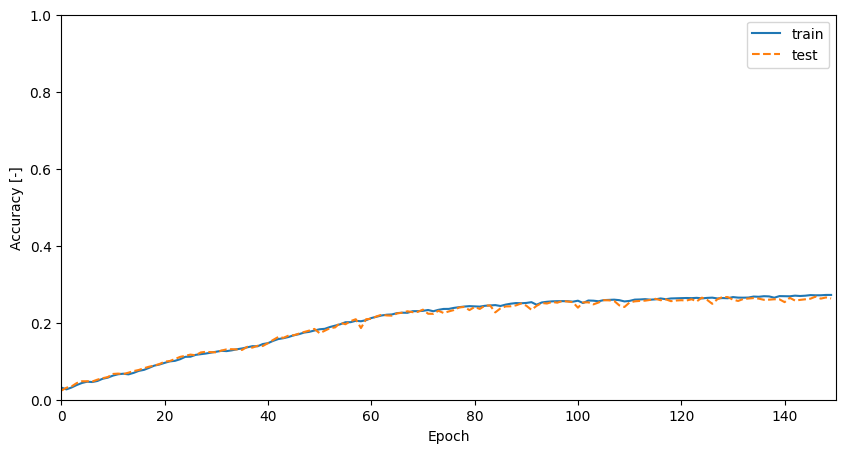

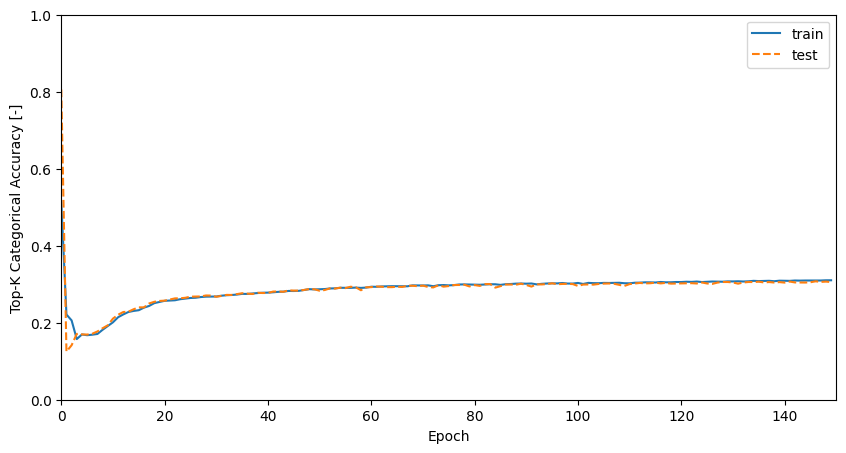

In [17]:
show_plots(history_5, "att_5gap")